In [152]:
import os

# Check if the notebook is running on Colab
if 'COLAB_GPU' in os.environ:
    # This block will run only in Google Colab
    IN_COLAB = True
    print("Running on Google Colab. Cloning the repository.")
    !git clone https://github.com/pedro15sousa/energy-based-models-compression.git
    %cd energy-based-models-compression/notebooks
else: 
    # This block will run if not in Google Colab
    IN_COLAB = False
    print("Not running on Google Colab. Assuming local environment.")

Not running on Google Colab. Assuming local environment.


In [153]:
import sys
sys.path.append('..')  # This adds the parent directory (main_folder) to the Python path

In [154]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.utils.data as data
import torch.nn.utils.prune as prune

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning
    import pytorch_lightning as pl
# Callbacks
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
# Pytorch Summary
try:
    from torchsummary import summary
except ModuleNotFoundError:
    !pip install --quiet torchsummary
    from torchsummary import summary

import numpy as np
import pandas as pd
import json
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

from metrics.classifier import VGG
from metrics.scores import frechet_inception_distance, inception_score
from EBM import DeepEnergyModel
from energy_funcs.cnn import CNNModel
from sampler import Sampler
from callbacks import InceptionScoreCallback, \
    FIDCallback, SamplerCallback, OutlierCallback, \
    GenerateImagesCallback, DummyGenerateImagesCallback

import shutil
if IN_COLAB:
    from google.colab import files

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models"

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", device)

pl.seed_everything(43)

/var/folders/pl/gjvtfzbj4691nr_0pszjdspw0000gn/T/ipykernel_28010/2722556781.py:36: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 43


Device:  cpu


43

In [155]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial8/"
# Files to download
pretrained_files = ["MNIST.ckpt", "tensorboards/events.out.tfevents.MNIST"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [156]:
# Transformations applied on each image => make them a tensor and normalize between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True,  drop_last=True,  num_workers=2, pin_memory=True)
test_loader  = data.DataLoader(test_set,  batch_size=128, shuffle=False, drop_last=False, num_workers=2)

In [157]:
if os.path.exists('../saved_models/mnist-classifier-1 (1).pth'):
    # Load the best model
    mnist_classifier = VGG()

    if device == 'cuda':
        mnist_classifier.load_state_dict(torch.load('../saved_models/mnist-classifier-1 (1).pth'))
    else:
        mnist_classifier.load_state_dict(torch.load('../saved_models/mnist-classifier-1 (1).pth', map_location=torch.device('cpu')))

    mnist_classifier.to(device)
    print("Model already exists and loaded.")
    summary(mnist_classifier, input_size=(1, 28, 28))
else:
    print("Classifier not found in saved_models. Please run the classifier notebook first.")

Model already exists and loaded.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
              ReLU-2          [-1, 128, 28, 28]               0
            Conv2d-3          [-1, 128, 28, 28]         147,584
              ReLU-4          [-1, 128, 28, 28]               0
            Conv2d-5          [-1, 128, 28, 28]         147,584
              ReLU-6          [-1, 128, 28, 28]               0
         MaxPool2d-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 256, 14, 14]         295,168
              ReLU-9          [-1, 256, 14, 14]               0
           Conv2d-10          [-1, 256, 14, 14]         590,080
             ReLU-11          [-1, 256, 14, 14]               0
           Conv2d-12          [-1, 256, 14, 14]         590,080
             ReLU-13          [-1, 256, 14, 14]               0
      

In [158]:
class EBM_Tutorial(pl.LightningModule):

    def __init__(self, img_shape, batch_size, alpha=0.1, lr=1e-4, beta1=0.0, **CNN_args):
        super().__init__()
        self.save_hyperparameters()

        self.cnn = CNNModel(**CNN_args)
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size)
        self.example_input_array = torch.zeros(1, *img_shape)

    def forward(self, x):
        z = self.cnn(x)
        return z

    def configure_optimizers(self):
        # Energy models can have issues with momentum as the loss surfaces changes with its parameters.
        # Hence, we set it to 0 by default.
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97) # Exponential decay over epochs
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # We add minimal noise to the original images to prevent the model from focusing on purely "clean" inputs
        real_imgs, _ = batch
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)

        # Obtain samples
        fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)

        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        # Calculate losses
        reg_loss = self.hparams.alpha * (real_out ** 2 + fake_out ** 2).mean()
        cdiv_loss = fake_out.mean() - real_out.mean()
        loss = reg_loss + cdiv_loss

        # Logging
        self.log('loss', loss)
        self.log('loss_regularization', reg_loss)
        self.log('loss_contrastive_divergence', cdiv_loss)
        self.log('metrics_avg_real', real_out.mean())
        self.log('metrics_avg_fake', fake_out.mean())
        return loss

    def validation_step(self, batch, batch_idx):
        # For validating, we calculate the contrastive divergence between purely random images and unseen examples
        # Note that the validation/test step of energy-based models depends on what we are interested in the model
        real_imgs, _ = batch
        fake_imgs = torch.rand_like(real_imgs) * 2 - 1

        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        cdiv = fake_out.mean() - real_out.mean()
        self.log('val_contrastive_divergence', cdiv)
        self.log('val_fake_out', fake_out.mean())
        self.log('val_real_out', real_out.mean())

In [8]:
class DownloadCheckpointCallback(pl.Callback):
    def __init__(self, download_dir, every_n_epochs=5):
        """
        Args:
            download_interval (int): Number of epochs between downloads.
            download_dir (str): Directory to download checkpoints to.
        """
        self.every_n_epochs = every_n_epochs
        self.download_dir = download_dir

    def on_train_epoch_end(self, trainer, pl_module, unused=None):
        epoch = trainer.current_epoch
        if epoch % self.every_n_epochs == 0:
            if IN_COLAB:
                shutil.make_archive(f'MNIST_{epoch}', 'zip', self.download_dir)
                files.download(f'MNIST_{epoch}.zip')
            else:
                return

In [82]:
def calculate_fid(real_imgs, fake_imgs, mnist_classifier):
    # Function to calculate the FID score

    def extract_features(images, model):
        # Function to extract features from images using the provided model
        model.eval()
        with torch.no_grad():
            features = model.get_activations(images)
        return features.cpu().numpy()

    # Extract features from real and fake images
    real_features = extract_features(real_imgs, mnist_classifier)
    fake_features = extract_features(fake_imgs, mnist_classifier)

    fid_score = frechet_inception_distance(real_features, fake_features)
    
    return fid_score

In [103]:
def apply_unstructured_pruning(model, backbone=True, amount=0.5):
    """Applies unstructured L1 pruning to the specified layers in the model.
    
    Args:
        model (nn.Module): The neural network model to prune.
        backbone (bool): If True, prune only Conv2d layers. If False, prune all layers.
        amount (float): The fraction of weights to prune.
    """
    for module in model.modules():
        # If backbone is True, prune only Conv2d layers
        if backbone and isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')
        # If backbone is False, prune all layers with weights
        elif not backbone and hasattr(module, 'weight'):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')

In [145]:
def apply_structured_pruning(model, backbone=True, amount=0.5):
    """Applies structured Ln pruning to the specified layers in the model.
    
    Args:
        model (nn.Module): The neural network model to prune.
        backbone (bool): If True, prune only Conv2d layers. If False, prune all layers.
        amount (float): The fraction of weights to prune.
    """
    for module in model.modules():
        # If backbone is True, prune only Conv2d layers
        if backbone and isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=amount, n=1, dim=0)  # dim=0 for filter pruning)
            prune.remove(module, 'weight')
        # If backbone is False, prune all layers with weights
        elif not backbone and hasattr(module, 'weight'):
            prune.ln_structured(module, name='weight', amount=amount, n=1, dim=0)  # dim=0 for filter pruning)
            prune.remove(module, 'weight')

In [147]:
def get_pruned_model(model, struct=False, backbone=True, amount=0.2):
    pruned_model = copy.deepcopy(model)
    if struct:
        apply_structured_pruning(model=pruned_model, backbone=backbone, amount=amount)
    else:
        apply_unstructured_pruning(model=pruned_model, backbone=backbone, amount=amount)
    
    return pruned_model


In [148]:
def get_images(model, train=False):
    data_loader = train_loader if train else test_loader
    real_imgs = None
    for imgs, _ in data_loader:
        real_imgs = imgs.cpu() # Move to CPU 
        break  # Only one batch is needed
    
    batch_size = real_imgs.shape[0]
    callback = DummyGenerateImagesCallback(batch_size=batch_size, vis_steps=8, num_steps=1)
    fake_imgs = callback.generate_imgs(model)
    fake_imgs = fake_imgs.squeeze(0).cpu()

    return real_imgs, fake_imgs

In [165]:
pretrained_filename = os.path.join(CHECKPOINT_PATH, "MNIST.ckpt")
model = EBM_Tutorial.load_from_checkpoint(pretrained_filename)
# model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
summary(model, input_size=(1, 28, 28))
# pl.seed_everything(43)


Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/MNIST.ckpt`


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             416
             Swish-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           4,640
             Swish-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          18,496
             Swish-6             [-1, 64, 4, 4]               0
            Conv2d-7             [-1, 64, 2, 2]          36,928
             Swish-8             [-1, 64, 2, 2]               0
           Flatten-9                  [-1, 256]               0
           Linear-10                   [-1, 64]          16,448
            Swish-11                   [-1, 64]               0
           Linear-12                    [-1, 1]              65
         CNNModel-13                       [-1]               0
Total params: 76,993
Trainable params: 

# Post-training Pruning

## Ustructured

In [160]:
def pruned_fid_scores(model, struct, backbone, train=False):
    fid_scores = []
    for amount in np.arange(0.1, 1.0, 0.1):
        pruned_model = get_pruned_model(model, struct=struct, backbone=backbone, amount=amount)
        pruned_model.to(device)

        real_imgs, fake_imgs = get_images(pruned_model, train=train)
        fid_score = calculate_fid(real_imgs, fake_imgs, mnist_classifier)

        perc = amount * 100
        print(f"FID Score on backpone post-training pruning of {perc}% of the EBM: ", fid_score)

        fid_scores.append(fid_score)

    return fid_scores

In [166]:
un_backbone_fid_scores = pruned_fid_scores(model, struct=False, backbone=True, train=False)
print("\n")
un_global_fid_scores = pruned_fid_scores(model, struct=False, backbone=False, train=False)
print("\n")
struct_backbone_fid_scores = pruned_fid_scores(model, struct=True, backbone=True, train=False)
print("\n")
struct_global_fid_scores = pruned_fid_scores(model, struct=True, backbone=False, train=False)

FID Score on backpone post-training pruning of 10.0% of the EBM:  5299.144251930401
FID Score on backpone post-training pruning of 20.0% of the EBM:  5251.00710543481
FID Score on backpone post-training pruning of 30.000000000000004% of the EBM:  5371.944219956912
FID Score on backpone post-training pruning of 40.0% of the EBM:  5283.825084455144
FID Score on backpone post-training pruning of 50.0% of the EBM:  5266.001710145578
FID Score on backpone post-training pruning of 60.0% of the EBM:  5538.081841414348
FID Score on backpone post-training pruning of 70.0% of the EBM:  5741.454070977487
FID Score on backpone post-training pruning of 80.0% of the EBM:  5644.91086350064
FID Score on backpone post-training pruning of 90.0% of the EBM:  5770.122114921397


FID Score on backpone post-training pruning of 10.0% of the EBM:  5230.616687257472
FID Score on backpone post-training pruning of 20.0% of the EBM:  5222.067407616949
FID Score on backpone post-training pruning of 30.000000000000

Seed set to 43


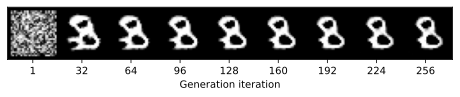

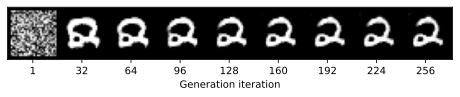

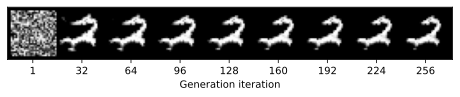

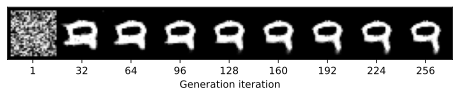

In [170]:
uns_pruned_model = get_pruned_model(model, struct=False, backbone=True, amount=0.0)
callback = DummyGenerateImagesCallback(batch_size=4, vis_steps=8, num_steps=256)
imgs_per_step = callback.generate_imgs(model)
imgs_per_step = imgs_per_step.cpu()
pl.seed_everything(43)

for i in range(imgs_per_step.shape[1]):
    step_size = callback.num_steps // callback.vis_steps
    imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
    imgs_to_plot = torch.cat([imgs_per_step[0:1,i],imgs_to_plot], dim=0)

    # Normalize the images
    imgs_to_plot = (imgs_to_plot + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
    grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True)
                
    # grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1,1), pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8,8))
    plt.imshow(grid)
    plt.xlabel("Generation iteration")
    plt.xticks([(imgs_per_step.shape[-1]+2)*(0.5+j) for j in range(callback.vis_steps+1)],
               labels=[1] + list(range(step_size,imgs_per_step.shape[0]+1,step_size)))
    plt.yticks([])
    plt.show()